# <center>Music Prediction</center>


In this file, we use a neural network to predict the genre of music from 8 bars.

We copied a lot from Homework 4 because we have already done the work of creating neural networks.

# Essential imports and ground constants
Run everything in the following cells to get basic data and imports.

In [7]:
import os
import json
import mido
from mido import MidiFile
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import plotly
import plotly.graph_objects as go
import random, time
from collections import Counter
from sklearn.model_selection import train_test_split
import json
import math
from sklearn.datasets import fetch_openml
from json import JSONEncoder

In [8]:
##make sure to set WORKING_DIRECTORY to where the 'Data' folder is at
WORKING_DIRECTORY = r"C:\Users\harki\MAT180_Final_Project\Data"

##this specifies how deep to search every folder in 'Data'.
FILE_DEPTH = 3

##this specifies how many notes we want to compute later, quantized to sixteenth notes
##so 8 bars in common time is equal to a capacity of 128
CAPACITY = 256

##if our dataset grows, change this to reflect new genres added
##alternatively, we can use the number of keys in genres_dict instead.
UNIQUE_GENRES = 18

# Important preprocessing methods
Run everything below to get necessary methods for preprocessing the data/

In [9]:
def memoize(f):
    Cache = {}
    
    def f_memoized(*args):
        if (f, args) in Cache:
            return Cache[(f, args)]
        result = f(*args)
        Cache[(f, args)] = result
        return result
    
    return f_memoized

def getNotes(mid,trackNo):
    notes = []
    for msg in mid.tracks[trackNo]:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes  

def getNotesTrack(track):
    notes = []
    for msg in track:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes

def quantize16(notes):
    for i in range(len(notes)):
        if notes[i].velocity == 0 and notes[i].time > 50 and notes[i].time <= 60:
            notes[i] = notes[i].copy(time = 113)
    return notes

def absolutize(notes):
    #this methods returns a dictionary with notes matching the exact time
    for i in range(1,len(notes)):
        notes[i] = notes[i].copy(time = notes[i].time + notes[i-1].time)
    return notes

def trim(notes,capacity, pad = True):
    trimmed = []
    count = 0
    while count < capacity and count < len(notes):
        trimmed.append(notes[count])
        count += 1
    if pad == True:
        emptyNote = mido.Message('note_on', velocity = 0)
        while len(trimmed) < capacity:
            trimmed.append(emptyNote)
    return trimmed

@memoize
def getMidiFile(name):
    os.chdir(WORKING_DIRECTORY)
    found = False
    depth = FILE_DEPTH
    ##should never return "File not found!" if you are using genres_dict
    return getMidiFileRecur(name,found,depth)

getMidiFile = memoize(getMidiFile)
    
def getMidiFileRecur(name,found,depth):
    if depth >= 1:
        for element in os.listdir():
            if os.path.isdir(os.getcwd() + "/" + element):
                os.chdir(os.getcwd() + "/" + element)
                midi_names = []
                midi_names = collect_midi_files(midi_names)
                if name in midi_names:
                    found = True
                    return getMidiFileRecur(name,found,depth-1)
                    break
                os.chdir("..")
    else:
        if found == True:
            return MidiFile(name, clip = True)
        else:
            return "File not found!"
    return "File not found!"

#takes a MidiFile and returns only the trimmed notes
def compress(midiFile, pad = True):
    list = []
    for tracks in midiFile.tracks:
        list.append(tracks)
    
    merged = mido.merge_tracks(list)
    merged = getNotesTrack(merged)
    merged = trim(merged, CAPACITY, pad)
    
    return merged

def decoder(array):
    list = []
    for keys in genres_dict.keys():
        list.append(keys)
    index = np.argmax(array)

    return list[index]

#this returns a dictionary 
def genADLData(size):
    list = []
    for key in genres_dict.keys():
        list.append(key)
    genres = []
     
    for i in range(size):
        r = random.randint(0,len(list)-1)
        genres.append(list[r])
    
    music = []
    for item in genres:
        music = music + random.sample(genres_dict[item],1)    
    return genres,music

#gets MidiFiles from a list with str music entires
def getMidiList(musicList):
    for i in range(len(musicList)):
        musicList[i] = getMidiFile(musicList[i])
    return musicList
        
#gets only notes from a list with str music entries
def getNotesFromList(musicList):
    outputList = []
    for i in range(len(musicList)):
        try:
            outputList.append( compress(getMidiFile(musicList[i])) )
        except:
            print(musicList[i],"caused an error! Ignoring this file for compression.")
            outputList.append( trim(getNotes( getMidiFile(musicList[i]) ,1),CAPACITY) )
    return outputList
        
# print(music)
# print(len(getNotesFromList(music)[1]))

##create the dataset and associated labels
##first pick random genre, and then pick a random song from that genre
# genre = random.sample(sorted(genres_dict),1)[0]
# music = random.sample(genres_dict[genre],1)[0]

# print(genre,",",music)

# Forming genres_dict
From the folder 'Data', we create a dictionary `genres_dict` which contains keys as genres and elements of that key as lists of music associated with that genre. If you want to load the entire set which contains corrupted data as well, run the following cell. If not, skip to <b>Load Uncorrupted Genres_Dict</b>

In [4]:
# collects midi files from a given folder
def collect_midi_files(midi_files):
    for element in os.listdir():
        if os.path.isdir(os.getcwd() + "/" + element):
            # print(f'folder: {element}')
            os.chdir(os.getcwd() + "/" + element)
            midi_files = collect_midi_files(midi_files)
            os.chdir("..")
        elif element.endswith(".mid"): # change to .mid
            # print(f'file: {element}')
            midi_files.append(element)
    return midi_files

os.chdir(WORKING_DIRECTORY)

genres_dict = {}

for element in os.listdir():
    if os.path.isdir(os.getcwd() + "/" + element):
        os.chdir(os.getcwd() + "/" + element)
        midi_names = []
        midi_names = collect_midi_files(midi_names)
        if midi_names != []:
            genres_dict[element] = midi_names
        os.chdir("..")

print(genres_dict)

count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1
print("\ngenres_dict has",count,"elements")

{'Ambient': ['Sunburst (Album Version).mid', 'While The City Sleeps (Album Version).mid', 'Forever Free.mid', 'Lagt Kort Ligger.mid', 'Paula_ Tva Ar.mid', 'Come Speak To Me.mid', 'Rainbow.mid', 'Tell Me.mid', 'The Sea and The Sky.mid', 'Mary Is Coming (2006 Remastered LP Version).mid', 'Ave maria.mid', 'Na Voz do Coracao.mid', 'Sweet Symphony.mid', 'Plays John Cassavettes Pt 2.mid', 'Blue Bayou.mid', 'Crazy.mid', 'Killing Me Softly.mid', 'Les feuilles mortes.mid', 'Twilight Time.mid', 'Wonderful World.mid', 'The Nutcracker - Coffee (Arabian Dance).mid', 'White Christmas.mid', 'All By Myself.mid', 'All The Things You Are.mid', 'Ave Maria (Schubert).mid', 'Ballade Pour Adeline.mid', 'Blue Eyes.mid', 'Bright Eyes.mid', 'Can You Feel The Love Tonight.mid', 'How Deep Is Your Love.mid', 'How Do I Live.mid', 'I Dreamed A Dream.mid', 'La Pathetique  Piano Sonata No 8 in C minor_ Op 13.mid', 'Largo.mid', 'Long Ago And Far Away.mid', 'Love Story.mid', 'Marriage DAmour.mid', 'My Way.mid', 'Only Y

Like many massive datasets uncautiously curated, there are corrupted data. Below is an example

In [10]:
#example corrupted Midi file
mid = getMidiFile('Fig Leaf Rag.mid')

KeySignatureError: Could not decode key with 8 sharps and mode 0

This method below removes all corrupted data from genres_dict. Running cleanData() will take approximately an hour.

In [ ]:
# genres_dict = {'Ambient':['Fig Leaf Rag.mid','Edvard Grieg Ich liebe dich.mid']}
@memoize
def cleanData():
    errorCount = 0
    count = 0
    for keys in genres_dict.keys():
        for item in genres_dict[keys]:
            if count%100 == 0 and count > 1:
                print("Went through",count,"files so far.")
            try:
                getMidiFile(item)
            except:
                genres_dict[keys].remove(item)
                errorCount += 1
            count += 1

    count = 0
    for keys in genres_dict.keys():
        for list in genres_dict[keys]:
            count += 1
    print("There were",errorCount,"corrupted files.")
    print("Uncorrupted genres_dict has",count,"files.")

In [ ]:
##takes approximately an hour
cleanData()

# Load Uncorrupted genres_dict
This cell below returns `genres_dict` just like above, but without corrupted files and is much faster.

In [11]:
os.chdir(WORKING_DIRECTORY)
os.chdir("..")

with open('uncorrupted.txt') as f:
    data = f.read()

genres_dict = json.loads(data)

print(genres_dict)
count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1
print("\nUncorrupted genres_dict has",count,"elements")

{'Ambient': ['Sunburst (Album Version).mid', 'While The City Sleeps (Album Version).mid', 'Forever Free.mid', 'Lagt Kort Ligger.mid', 'Paula_ Tva Ar.mid', 'Come Speak To Me.mid', 'Rainbow.mid', 'Tell Me.mid', 'The Sea and The Sky.mid', 'Mary Is Coming (2006 Remastered LP Version).mid', 'Ave maria.mid', 'Na Voz do Coracao.mid', 'Sweet Symphony.mid', 'Plays John Cassavettes Pt 2.mid', 'Blue Bayou.mid', 'Crazy.mid', 'Killing Me Softly.mid', 'Les feuilles mortes.mid', 'Twilight Time.mid', 'Wonderful World.mid', 'The Nutcracker - Coffee (Arabian Dance).mid', 'White Christmas.mid', 'All By Myself.mid', 'All The Things You Are.mid', 'Ave Maria (Schubert).mid', 'Ballade Pour Adeline.mid', 'Blue Eyes.mid', 'Bright Eyes.mid', 'Can You Feel The Love Tonight.mid', 'How Deep Is Your Love.mid', 'How Do I Live.mid', 'I Dreamed A Dream.mid', 'La Pathetique  Piano Sonata No 8 in C minor_ Op 13.mid', 'Largo.mid', 'Long Ago And Far Away.mid', 'Love Story.mid', 'Marriage DAmour.mid', 'My Way.mid', 'Only Y

# Neural Network functions

Running the cell below gives you absolutely everything you need for a feedfoward neural network we will use in this notebook.

In [12]:
# run this cell to import needed modules and define plotting functions (no input needed)
# function to plot costs
def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.show()
    
# function to plot costs
def plot_grads(grads):
    plt.plot(grads)
    plt.xlabel("iterations")
    plt.ylabel("gradient norm")
    plt.show()

# defining a function to plot data
def plot_data(X,Y,size_ = 2):
    m = len(X)
    plot_figure = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))])
    plotly.offline.iplot(plot_figure)

# defining a function to plot models fit
def plot_fit(X,Y,W,B,G,size_ = 2):
    trace = go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))
    xs,ys = X[:,0],X[:,1]
    xxx = np.outer(np.linspace(min(xs), max(xs), 30), np.ones(30))
    yyy = np.outer(np.linspace(min(ys), max(ys), 30), np.ones(30)).T
    zzz = np.zeros([30,30])
    D = len(G)-1
    for i in range(30):
        for j in range(30):
            zzz[i,j] = feedforward(W,B,G,np.array([xxx[i,j],yyy[i,j]]))[D][0]
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace,go.Surface(x=xxx, y=yyy, z=zzz, showscale=False, opacity=0.5)]
    # Render the plot.
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=[min(X[:,0]),max(X[:,0])],),
            yaxis = dict(nticks=4, range=[min(X[:,1]),max(X[:,1])],),
            zaxis = dict(nticks=4, range=[min(Y),max(Y)],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))
    plotly.offline.iplot(plot_figure)

def ReLU(x,deriv = False):
    if deriv == True:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [1]
            else:
                Hx = Hx + [0]
        return np.diag(np.array(Hx)) 
    else:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [element]
            else:
                Hx = Hx + [0]
        return np.array(Hx)

def Linear(x,deriv = False):
    if deriv == True:
        if type(x) != np.ndarray:
            return np.array([1])
        else:
            return np.eye(x.shape[0])
    else:
        Lx = []
        for element in x:
            Lx = Lx + [element]
        return np.array(Lx)

def Sigmoid(x,deriv = False):
    if deriv == True:
        y = Sigmoid(x,deriv = False)
        ones = np.ones(y.shape)
        return np.diag( y*(ones - y) )  
    else:
        Sgx = []
        for element in x:
            Sgx = Sgx + [1/(1+math.e**(-element))]
        return np.array(Sgx)

def Squared(x,deriv = False):
    if deriv == True:
        return np.diag( 2*x)  
    else:
        Sqx = []
        for element in x:
            Sqx = Sqx + [element**2]
        return np.array(Sqx)

def Softmax(x,deriv = False):
    totalSum = np.sum(np.exp(x))
    out = np.zeros(len(x))
    for i in range(len(x)):
        out[i] = np.exp(x[i]) / totalSum
    
    if deriv:
        return np.diagflat(out) - np.outer(out, out)
    else:
        return out

def loss(Nx,y,cost_type,deriv = False):
    if deriv == True:
        if cost_type == 'ce':
            return -1*y.T*(1/Nx)    
        elif cost_type == 'bce': 
            return -y/Nx + (1-y)/(1-Nx)  
        else: 
            return 2*(Nx-y).T    
    else:
        if cost_type == 'ce':
            return -1*y.T@np.log(Nx)
        if cost_type == 'bce':
            return -y.T@np.log(Nx) -(1-y).T@np.log(1-Nx)
        
        else:
            return LA.norm(Nx-y,2)**2
        
def feedforward(W,B,G,x):
    x0 = G[0](x)
    s0 = W[0]@x0+B[0]
    feeds = [ [x0,s0] ]    
    depth = len(W)
    for i in range(1,depth):
        xi = G[i](feeds[i-1][1])
        si = W[i]@xi+B[i]
        feeds = feeds + [ [xi,si] ]   
    xfinal = G[depth](feeds[depth-1][1])
    feeds = feeds + [ xfinal ]
    return feeds      

def deltas(X_feeds,Y,W,B,G,verbose = False, cost_type = 'se'):
    depth = len(W)
    deltas_dict = {}
    deltas_list = []
    for key in X_feeds.keys():
        Nx = X_feeds[key][-1]
        y = Y[key]
        sd_1 = X_feeds[key][-2][1]
        delta_d_1 = loss(Nx, y, cost_type,deriv = True)@G[depth](sd_1,deriv = True)
        deltas_list = deltas_list + [delta_d_1]
        for l in range(depth-1,0,-1):
            sl = X_feeds[key][l-1][1]
            delta = deltas_list[-1]@W[l]@G[l](sl,deriv=True)
            deltas_list = deltas_list + [delta]
        deltas_list.reverse()
        deltas_dict.update({key:deltas_list})
    return deltas_dict

def grads(X,Y,W,B,G,batch, lambda_ = 0, verbose = False,cost_type = 'se'):
    X_feeds = {}
    for i in batch:
        xi = X[i,:]
        X_feeds.update({i:feedforward(W,B,G,xi)})
    depth = len(W)
    dWs,dBs = [],[]
    X_deltas = deltas(X_feeds,Y,W,B,G,verbose, cost_type)
    for l in range(depth):
        dWsum = 0
        dBsum = 0
        for i in batch:
            x_l = X_feeds[i][l][0]
            x_delta_l = X_deltas[i][l]
            dWsum = dWsum + np.outer(x_delta_l,x_l) + 2*lambda_*W[l]
            dBsum = dBsum + x_delta_l
        dWs = dWs + [1/len(batch)*dWsum]
        dBs = dBs + [1/len(batch)*dBsum]
    return dWs,dBs,X_feeds

def fit(X,Y,arch,G,alpha = 1e-9, momentum = .01, batch_size = 100, 
        lambda_ = 0, max_iters = 100,verbose = False, cost_type = 'se',print_costs = True):
    W,B,VW,VB = [],[],[],[]
    D,m = len(G)-1,len(X)
    for l in range(D):
        W = W + [ np.random.normal( 0, 2/(arch[l]+arch[l+1]), (arch[l+1],arch[l]) ) ]
        B = B + [ np.zeros(arch[l+1])]
        VW = VW + [np.zeros(W[l].shape)]
        VB = VB + [np.zeros(B[l].shape)]
    epochs = 0
    costs = []
    tempcosts = []
    grad_norms = []
    while epochs <= max_iters:
        if epochs%(np.floor(max_iters/30))==0 and print_costs == True and costs != []:
            print(f'epoch: {epochs}')
            print(f'           cost: {costs[-1]}')
        batch = random.sample(range(m),batch_size)
        dWs,dBs,feeds = grads(X,Y,W,B,G,batch,lambda_,verbose,cost_type)
        for i in range(len(dWs)):
            norm = LA.norm(dWs[i],2) + LA.norm(dBs[i],2)
            grad_norms = grad_norms + [ norm ]
        tempCosts = 0
        for i in batch:
            Nx = feeds[i][D]
            y = Y[i]
            J = loss(Nx,y,cost_type)
            tempCosts = tempCosts + J/len(batch)
        costs = costs + [tempCosts]
        for l in range(D):
            VW[l] = momentum*VW[l] - alpha*dWs[l]
            VB[l] = momentum*VB[l] - alpha*dBs[l]
            W[l] = W[l] + VW[l]
            B[l] = B[l] + VB[l]
        epochs = epochs + 1
    return W,B,costs,grad_norms
        
def predict(W,B,G,x,output_type = 'vector'):
    prediction = feedforward(W,B,G,x)[-1]
    out = np.zeros(prediction.shape[0])
    out[np.argmax(prediction)] = 1
    
    if output_type == 'vector':
        return out
    
    elif output_type == 'genre':
        return decoder(out)

# Music Prediction

The goal of this problem is the classify the music samples correctly. This is similar to the multiclass classifier used for the iris dataset, and our accuracy functions will actually be exactly the same.

# Forming the dataset

Now, we form a dataset from the ADL files. The cell below will generate three copies of the data, one for pitch, velocity and time deltas. Feel free to change value for `size`.

In [13]:
#shape data into readable form by NN:
size = 3000 #must be at least 1!
#takes approximately 10 minutes to load 1000 examples

def checkCompressible(genre,music):
    outputList = []
    for i in range(len(music)):
        if i > 1 and i % 100 == 0:
            print(i,"files collected so far.")
        try:
            outputList.append( compress(getMidiFile(music[i])) )
        except:
            print(music[i],"caused an error! Ignoring this file for compression.")
            del genre[i]
    return outputList
    

#list of genres and names of the music randomly sampled:
genres, music = genADLData(size)
#since we are not interested in other midi metadata, and we are collapsing all tracks into one (chordizing), we
#extract only the notes from the midi file associated with its name.
notesList = checkCompressible(genres,music)

#initialize and fill X
X = np.atleast_2d(np.array(notesList[0]))
for i in range(1,len(notesList)):
    X_row = np.atleast_2d(np.array(notesList[i]))
    X = np.concatenate((X,X_row),axis = 0)

#fill Y, our labels
Y = np.atleast_2d(np.array(genres)).T

#generate dataset of pitches only:
def get_notes_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].note
    return A

#generate dataset of velocities only:
def get_velocities_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].velocity
    return A

#generate dataset of time deltas only:
def get_times_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].time
    return A

X_pitches = get_notes_from_dataset(X)
X_velocities = get_velocities_from_dataset(X)
X_times = get_times_from_dataset(X)

100 files collected so far.
Invention 6.mid caused an error! Ignoring this file for compression.
200 files collected so far.
300 files collected so far.
400 files collected so far.
500 files collected so far.
600 files collected so far.
700 files collected so far.
800 files collected so far.
900 files collected so far.
1000 files collected so far.
1100 files collected so far.
1200 files collected so far.
1300 files collected so far.
1400 files collected so far.
1500 files collected so far.
1600 files collected so far.
1700 files collected so far.
1800 files collected so far.
1900 files collected so far.
2000 files collected so far.
2100 files collected so far.
2200 files collected so far.
2300 files collected so far.
2400 files collected so far.
2500 files collected so far.
2600 files collected so far.
2700 files collected so far.
2800 files collected so far.
2900 files collected so far.


Now, let's encode `Y` with one-hot encoding. <b>Run this only once after running the previous cell.</b> (For some reason, I keep getting a FutureWarning error; this arises when using == to compare two different object types. But in the code below, everything is a string! I dont know how to solve this)

In [14]:
A = np.copy(Y)

length = len(genres_dict.keys())

list = []
A = A.flatten()
A = A.tolist()

for keys in genres_dict.keys():
    list.append(keys)
    
for i in range(len(A)):
    for j in range(len(list)):
        if A[i] == list[j]:
            A[i] = np.zeros(len(list))
            A[i][j] = 1
    
# decoder(A[0])
Y = np.array(A)

C:\Users\harki\AppData\Local\Temp\ipykernel_23668\1538615884.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if A[i] == list[j]:


# Creating train, test and validation sets
After selecting a subset of the data, we have to split into three sets for each pitch, velocity and times. This means there will be 9 split sets.

In [15]:
#creating validation and test set for pitches
X_pitches_train, X_pitches_test, y_pitches_train, y_pitches_test = train_test_split(X_pitches, Y, test_size=0.2, random_state=3)
X_pitches_train, X_pitches_val, y_pitches_train, y_pitches_val = train_test_split(X_pitches_train, y_pitches_train, test_size=0.25, random_state=4)

#creating validation and test set for velocities
X_velocities_train, X_velocities_test, y_velocities_train, y_velocities_test = train_test_split(X_velocities, Y, test_size=0.2, random_state=3)
X_velocities_train, X_velocities_val, y_velocities_train, y_velocities_val = train_test_split(X_velocities_train, y_velocities_train, test_size=0.25, random_state=4)

#creating validation and test set for times
X_times_train, X_times_test, y_times_train, y_times_test = train_test_split(X_times, Y, test_size=0.2, random_state=3)
X_times_train, X_times_val, y_times_train, y_times_val = train_test_split(X_times_train, y_times_train, test_size=0.25, random_state=4)

# # creating validation and test set
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4) # 0.25 x 0.8 = 0.2



# Fitting it all
And here we pick our architecture for our prediction model. We know that the last layer should have `Softmax` activation with (some number) of choices. We will use our prediction function to determine the accuracy later with `output_type = 'number'`.

In [16]:
#run this cell to get critical information about how our architecture should be, among other info
print("Input size is",CAPACITY)
print("Current directory is pointed to",WORKING_DIRECTORY)
print("Output size (number of genres) is",len(genres_dict.keys()))
print("Pitch training size:",X_pitches_train.shape)
# print("Velocity Training size:",X_velocities_train.shape)
# print("Time Deltas Training size:",X_times_train.shape)

Input size is 256
Current directory is pointed to C:\Users\harki\MAT180_Final_Project\Data
Output size (number of genres) is 18
Pitch training size: (1799, 256)


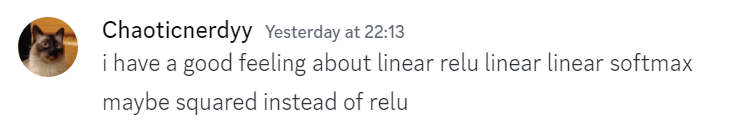

In [ ]:
arch = [CAPACITY, 128, 128, 32, UNIQUE_GENRES]
G = [Linear, Squared, ReLU, Linear, Softmax]
W,B,costs,grad_norms = fit(X_pitches_train,y_pitches_train,arch,G,alpha = 1e-3, 
                                momentum = .9,batch_size=100,lambda_=0,max_iters=15000,cost_type='se')

In [ ]:
# plot the costs
plot_costs(costs)

In [ ]:
# plot the gradient norms
plot_grads(grad_norms)

## Measuring performance

Here we compute the accuracy of our model. We want high, and relatively the same values on training, validation, and test accuracy to know we have chosen a good architecture and dealt with regularization.

In [ ]:
# compute training accuracy
correct = 0
predictions = []
for examples in X_pitches_train:
    predictions.append(predict(W,B,G,examples,output_type = 'genre'))
    
for i in range(len(y_pitches_train)):
    if predictions[i] == decoder(y_pitches_train[i]):
        correct += 1

print("Accuracy:",correct/len(y_pitches_train))

In [ ]:
# compute validation accuracy
correct = 0
predictions = []
for examples in X_pitches_val:
    predictions.append(predict(W,B,G,examples,output_type = 'genre'))
    
for i in range(len(y_pitches_val)):
    if predictions[i] == decoder(y_pitches_val[i]):
        correct += 1

print("Accuracy:",correct/len(y_pitches_val))

In [ ]:
# compute test accuracy
correct = 0
predictions = []
for examples in X_pitches_test:
    predictions.append(predict(W,B,G,examples,output_type = 'genre'))
    
for i in range(len(y_pitches_test)):
    if predictions[i] == decoder(y_pitches_test[i]):
        correct += 1

print("Accuracy:",correct/len(y_pitches_test))

# Save best architecture, weights and activations
<b>Do not run this cell if your accuracies were inferior in the previous run</b>. Use this cell to save your results.

In [ ]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

os.chdir(WORKING_DIRECTORY)
os.chdir('..')
WT,BT = W,B
jsonFile = open("weights.json", "w+")
jsonFile.seek(0) # absolute file positioning
jsonFile.truncate() # to erase all data 
jsonFile.close()
jsonFile = open("biases.json", "w+")
jsonFile.seek(0) # absolute file positioning
jsonFile.truncate() # to erase all data 
jsonFile.close()
jsonFile = open("arch.json", "w+")
jsonFile.seek(0) # absolute file positioning
jsonFile.truncate() # to erase all data 
jsonFile.close()
jsonFile = open("G.json", "w+")
jsonFile.seek(0) # absolute file positioning
jsonFile.truncate() # to erase all data 
jsonFile.close()
print('deleted old weights from weights.json and biases from biases.json')
# Serialization
Ws,Bs = {l:W[l] for l in range(len(W))},{l:B[l] for l in range(len(B))}
archs,Gs = {l:arch[l] for l in range(len(arch))},{l:str(G[l]) for l in range(len(G))}
print("serialized W,B,arch,G into JSON and saved to JSON files weights.json, biases.json, arch.json and G.json")
with open("weights.json", "w") as write_file:
    json.dump(Ws, write_file, cls=NumpyArrayEncoder)
with open("biases.json", "w") as write_file:
    json.dump(Bs, write_file, cls=NumpyArrayEncoder)
with open("arch.json", "w") as write_file:
    json.dump(archs, write_file, cls=NumpyArrayEncoder)
with open("G.json", "w") as write_file:
    json.dump(Gs, write_file, cls=NumpyArrayEncoder)

Load your previously saved results here

In [ ]:
# to fetch saved weights from local json file
fileObject = open("weights.json", "r")
jsonContent = fileObject.read()
Ws = json.loads(jsonContent)

fileObject = open("biases.json", "r")
jsonContent = fileObject.read()
Bs = json.loads(jsonContent)

# to fetch saved activations and architecture from local json file
fileObject = open("arch.json", "r")
jsonContent = fileObject.read()
archs = json.loads(jsonContent)

fileObject = open("G.json", "r")
jsonContent = fileObject.read()
Gs = json.loads(jsonContent)

# setting fetched parameters as our model parameters
W = [np.array(Ws[i]) for i in Ws.keys()]
B = [np.array(Bs[i]) for i in Bs.keys()]
arch = [archs[i] for i in archs.keys()]
G = [Linear, Squared, ReLU, Linear, Softmax]

print(f'current best architecture: {arch}')
print(f'current best activation structure: {G}')

# Music Generator

In [ ]:
#generatedOutput should be a list of size CAPACITY, actual_genre is a string of the genre
def encoder(genre):
    length = len(genres_dict.keys())

    list = []

    for keys in genres_dict.keys():
        list.append(keys)
        
    output = np.zeros(len(list))
        
    for j in range(len(list)):
        if genre == list[j]:
            output[j] = 1
            
    return output

encoder('Unknown')

#to do: change W,B,Gs to those in the pitch NN
def pitchAccuracy(generatedOutput, actual_genre):
    probability = feedforward(W,B,G,generatedOutput)[-1]
    correctIndex = np.argmax(encoder(actual_genre))
    return probability[correctIndex]

def generate(W,B,G,genre, outputSize, tolerance, max_iters):
    
    generatedOutput = []
    emptyNote = mido.Message('note_on')
    
    for i in range(0,outputSize):
        generatedOutput.append(emptyNote)
    
        

    i = 0
    while accuracy < tolerance and i < max_iters:
        
        
        #between A1 and G6
        pitch_pool = [range(21,127)]
        #between piano and fortissimo
        velocity_pool = [range(60,127)]
        #between semiquaver and semibreve
        time_pool = [range(113,1808)]
        
        
        
        #new pitch
        bestPitchAccuracy = 0
        for itemInPitchPool in pitch_pool:
            generatedOutput[i].copy(note=itemInPitchPool)
            pitchAccuracy = pitchAccuracy(generatedOutput,genre)
            if pitchAccuracy > bestPitchAccuracy:
                bestPitch = itemInPitchPool
        generatedOutput[i].copy(note=bestPitch)
        
        
        #associated velocity
        bestVelocityAccuracy = 0
        for itemInVelocityPool in velocity_pool:
            generatedOutput[i].copy(note=itemInVelocityPool)
            velocityAccuracy = velocityAccuracy(generatedOutput,genre)
            if velocityAccuracy > bestVelocityAccuracy:
                bestVelocity = itemInVelocityPool
        generatedOutput[i].copy(note=bestVelocity)
        
        
        #associated time delta
        timeDelta = random.choice(time_pool)
        
        generatedOutput[i].copy('note_on', note=pitch, velocity=vel, time=timeDelta)
        
        pitchAccuracy = pitchAccuracy(generatedOutput,genre)
        
    
#     predict(W,B,G,examples,output_type = 'genre',generatedOutput)
    
    